<a href="https://colab.research.google.com/github/MakowToms/DeepLearning/blob/main/speech/Speech_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Command Recognition 

Source: https://github.com/douglas125/SpeechCmdRecognition

This notebook presents an attention model for speech command recognotion. We use Google Speech Commands Dataset to test the Keras generator for sound files and the proposed RNN attention model.


## Download files and load information

Dynamically load speech data from the disk to allow handling big datasets.

First step: download Google Speech Command Dataset and convert all WAV files to numpy arrays for faster load (about 10x faster than loading raw WAV).

In [ ]:
# restart environment (use only if necessary)
import os
os.kill(os.getpid(), 9)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing

In [3]:
# unpack data on disk
# there should be prepared previously using audioUtils.WAV2Numpy
import zipfile

zip_file = "drive/MyDrive/speech_data/$name_filtered.zip"
unzip_train = True
unzip_test = True

try:
  if unzip_train:
    with zipfile.ZipFile(zip_file.replace('$name', 'train')) as z:
        z.extractall('speech_data')
  if unzip_test:
    with zipfile.ZipFile(zip_file.replace('$name', 'test')) as z:
        z.extractall('speech_data')
  print("Extracted all")
except:
    print("Invalid file")

Extracted all


## Processing


In [1]:
# download python scripts from github
# if you want to reproduce previous models search for them in github history or make changes as specified in report
# to change scripts it may be useful to use file editor with downloaded file
!rm SpeechDownloader.py
!rm SpeechGenerator.py
!rm SpeechModels.py
!rm audioUtils.py
useColab=True
if useColab:
    %tensorflow_version 2.x
    !wget -q https://raw.githubusercontent.com/MakowToms/DeepLearning/main/speech/SpeechDownloader.py
    !wget -q https://raw.githubusercontent.com/MakowToms/DeepLearning/main/speech/SpeechGenerator.py
    !wget -q https://raw.githubusercontent.com/MakowToms/DeepLearning/main/speech/audioUtils.py
    !wget -q https://raw.githubusercontent.com/MakowToms/DeepLearning/main/speech/SpeechModels.py

In [2]:
# imports
import os
import random
import librosa
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

import SpeechDownloader
import SpeechGenerator
import SpeechModels

In [3]:
# reproducibility of results
!pip install tensorflow-determinism

import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ['TF_DETERMINISTIC_OPS'] = '1'

def set_seed(seed=123):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)  
set_seed()


In [4]:
# prepare all data
# in case of silence task change task='silence'
gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(task='12cmd', drive_directory='')

Done preparing Google Speech commands dataset version 0


We should have 4 datasets, each with file names 'files' and their categories 'labels' in a dict.

In [5]:
# some debug info to see some variables - not really important
print(gscInfo.keys())
# print(gscInfo['train'].keys())
# print(len(gscInfo['train']['files']))
print(nCategs)
len(gscInfo['testREAL']['files'])
# print(np.unique(list(gscInfo['test']['labels'].values())))
# len([l for l in gscInfo['train']['labels'].values() if l == 1])


dict_keys(['train', 'test', 'val', 'testREAL'])
12


158538

# Speech Data Generator

Use Keras to create a generator that reads files on the fly.

In [6]:
# prepare data generators
sr = 16000 # sampling rate
iLen = 16000
trainGen = SpeechGenerator.SpeechGen(gscInfo['train']['files'], gscInfo['train']['labels'], 'train', shuffle=True, batch_size=64)
valGen = SpeechGenerator.SpeechGen(gscInfo['val']['files'], gscInfo['val']['labels'], 'val', shuffle=True)

# use batch_size = total number of files to read all test files at once
testGen  = SpeechGenerator.SpeechGen(gscInfo['test']['files'], gscInfo['test']['labels'], 'test', shuffle=False, batch_size=len(gscInfo['test']['files']))
try:
  testRGen = SpeechGenerator.SpeechGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], 'test', shuffle=False, batch_size=int(len(gscInfo['testREAL']['files'])/6))
  print(testRGen.__len__())
except:
  print('Cannot create test dataset')
# print(valGen.__len__())
print(len(gscInfo['testREAL']['files']))
print(len(gscInfo['testREAL']['labels']))
print(len(gscInfo['test']['files']))
print(len(gscInfo['test']['labels']))


6
158538
158538
6835
6835


# Spectrograms

Mainly visualizations - to see how te spectrogram look like

In [ ]:
from tensorflow.keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

melspecModel = Sequential()

melspecModel.add(Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                         padding='same', sr=sr, n_mels=80,
                         fmin=40.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='mel_stft') )

melspecModel.add(Normalization2D(int_axis=0))

melspecModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mel_stft (Melspectrogram)    (None, 80, 125, 1)        1091664   
_________________________________________________________________
normalization2d (Normalizati (None, 80, 125, 1)        0         
Total params: 1,091,664
Trainable params: 1,091,664
Non-trainable params: 0
_________________________________________________________________


In [ ]:
melspec = melspecModel.predict( audios.reshape((-1,1,iLen)) )
melspec.shape

(32, 80, 125, 1)

<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


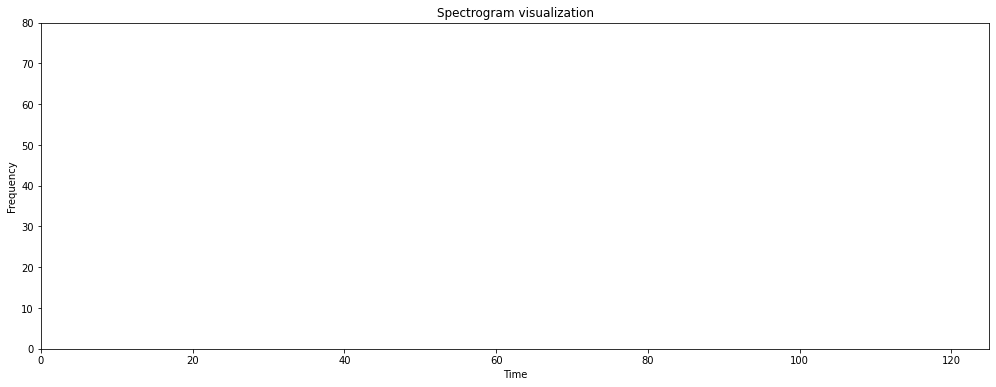

In [ ]:
plt.figure(figsize=(17,6))
plt.pcolormesh(melspec[9,:,:,0])

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [ ]:
# Check if mel spectrogram matches the one computed with librosa
librosa_melspec = librosa.feature.melspectrogram(y=audios[9], sr=sr, n_fft=1024,
                                                 hop_length=128, power=1.0, #window='hann',
                                                 n_mels=80, fmin=40.0, fmax=sr/2)
S_dB = librosa.power_to_db(librosa_melspec, ref=np.max)

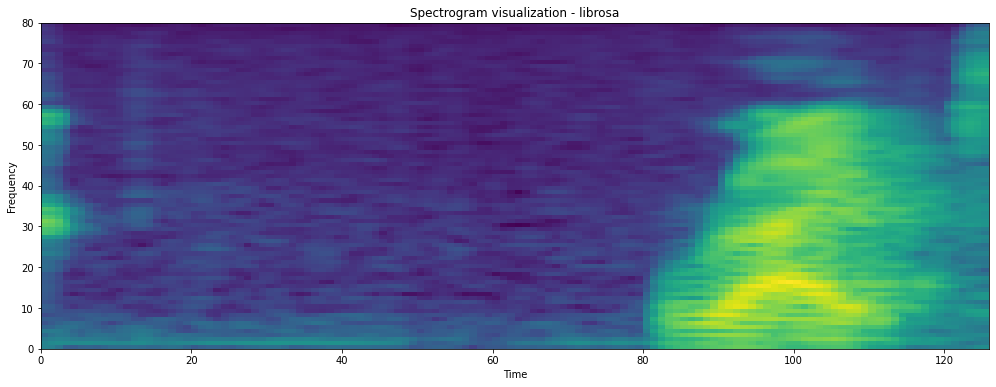

In [ ]:
plt.figure(figsize=(17,6))
plt.pcolormesh(S_dB)

plt.title('Spectrogram visualization - librosa')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [ ]:
# plt.hist(melspec.flatten(), bins=100)

# Models

Create Keras models to see if the generators are working properly

## Learn

In [7]:
from tensorflow.keras.models import Model, load_model

from kapre.time_frequency import Melspectrogram, Spectrogram
model_directory = 'drive/MyDrive/speech_data/model-12cmd-ConvAttRNN3-filtered.h5'

In [8]:
# usually set_seed with default parameter (123)
set_seed()
# create model: use one of possible in SpeechModels (there are also AttRNN, RNN, CNN)
# final model have also arguments: bigger_blocks=True, more_blocks=True
model = SpeechModels.ConvAttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = 16000) # , bigger_blocks=True, more_blocks=True)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 16000)]      0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 16000)     0           input[0][0]                      
__________________________________________________________________________________________________
mel_stft (Melspectrogram)       (None, 80, 125, 1)   1091664     reshape[0][0]                    
__________________________________________________________________________________________________
mel_stft_norm (Normalization2D) (None, 80, 125, 1)   0           mel_stft[0][0]                   
______________________________________________________________________________________________

In [ ]:
# interesting optimizer, because it decreases steadily learning rate
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [ ]:
# fit model (sometimes early stopper used different patience e.g. 3 or 10)
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint(model_directory, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results = model.fit(trainGen, validation_data=valGen, epochs=60, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, checkpointer, lrate])

model.save(model_directory)

Epoch 1/60
Changing learning rate to 0.001
560/560 - 120s - loss: 1.1455 - sparse_categorical_accuracy: 0.6067 - val_loss: 0.5814 - val_sparse_categorical_accuracy: 0.8086

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.80856, saving model to drive/MyDrive/speech_data/model-12cmd-ConvAttRNN3-filtered.h5
Epoch 2/60
Changing learning rate to 0.001
560/560 - 61s - loss: 0.5291 - sparse_categorical_accuracy: 0.8343 - val_loss: 0.3523 - val_sparse_categorical_accuracy: 0.8829

Epoch 00002: val_sparse_categorical_accuracy improved from 0.80856 to 0.88287, saving model to drive/MyDrive/speech_data/model-12cmd-ConvAttRNN3-filtered.h5
Epoch 3/60
Changing learning rate to 0.001
560/560 - 61s - loss: 0.4097 - sparse_categorical_accuracy: 0.8730 - val_loss: 0.3650 - val_sparse_categorical_accuracy: 0.8870

Epoch 00003: val_sparse_categorical_accuracy improved from 0.88287 to 0.88704, saving model to drive/MyDrive/speech_data/model-12cmd-ConvAttRNN3-filtered.h5
Epoch 4/60
Chan

## Plot

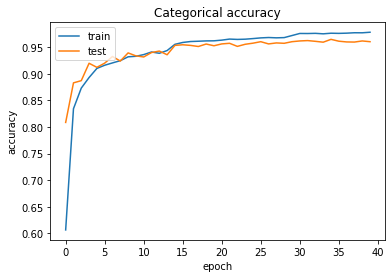

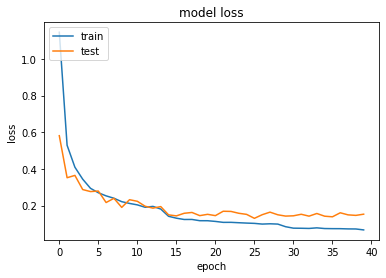

In [ ]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Accuracy on train, val and test


In [9]:
model_directory

'drive/MyDrive/speech_data/model-12cmd-ConvAttRNN3-filtered.h5'

In [10]:
# load best model
model.load_weights(model_directory)

In [ ]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [ ]:
valEval = model.evaluate(valGen, use_multiprocessing=False, workers=4,verbose=0)
trainEval = model.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
testEval = model.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.046598292887210846, 0.9857980012893677] 
Validation: [0.14188766479492188, 0.9648148417472839] 
Test: [1.9003888368606567, 0.41730996966362]


## Kaggle
code to predict and submit result

In [11]:
classes=['unknown', 'silence', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
# classes=['nothing', 'silence'] # use it if silence task
all_preds = []
for i in range(6):
    x_testR = None
    x_testR = testRGen.__getitem__(i)[0]
    y_pred = model.predict(x_testR, verbose=1)
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = [classes[i] for i in y_pred]
    all_preds += y_pred


826/826 [==============================] - 17s 20ms/step


In [12]:
files = gscInfo['testREAL']['files']
files = [file.split('/')[-1][:-4] for file in files]
submissions=pd.DataFrame({"fname": files,
                          "label": all_preds[:len(files)]}) #a_preds
submissions.to_csv("submission.csv", index=False)

In [13]:
# proportions of classes - really important
submissions.groupby('label').count()

,fname
label,
down,6234
go,6847
left,6099
no,6273
off,6765
on,6168
right,6781
silence,13403
stop,6026


In [14]:
!pip install kaggle
try:
    os.mkdir('/root/.kaggle')
except:
    pass
with open('/root/.kaggle/kaggle.json', 'w') as f:
    # have to write your own credentials (can be found in account menu)
    f.write('{"username":"your-username","key":"your-key"}')
!kaggle competitions submit -c tensorflow-speech-recognition-challenge -f submission.csv -m "12cmd-ConvAttRNN3-filtered"

100% 3.85M/3.85M [00:00<00:00, 7.15MB/s]
Successfully submitted to TensorFlow Speech Recognition Challenge

## Confusion matrix

In [ ]:
# x_test, y_test = testGen.__getitem__(0)
y_pred = model.predict(x_test, verbose=1)

345/345 [==============================] - 9s 21ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [ ]:
classes=['unknown', 'silence', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
# classes=['unknown', 'silence'] - use it if silence task

Confusion matrix, without normalization


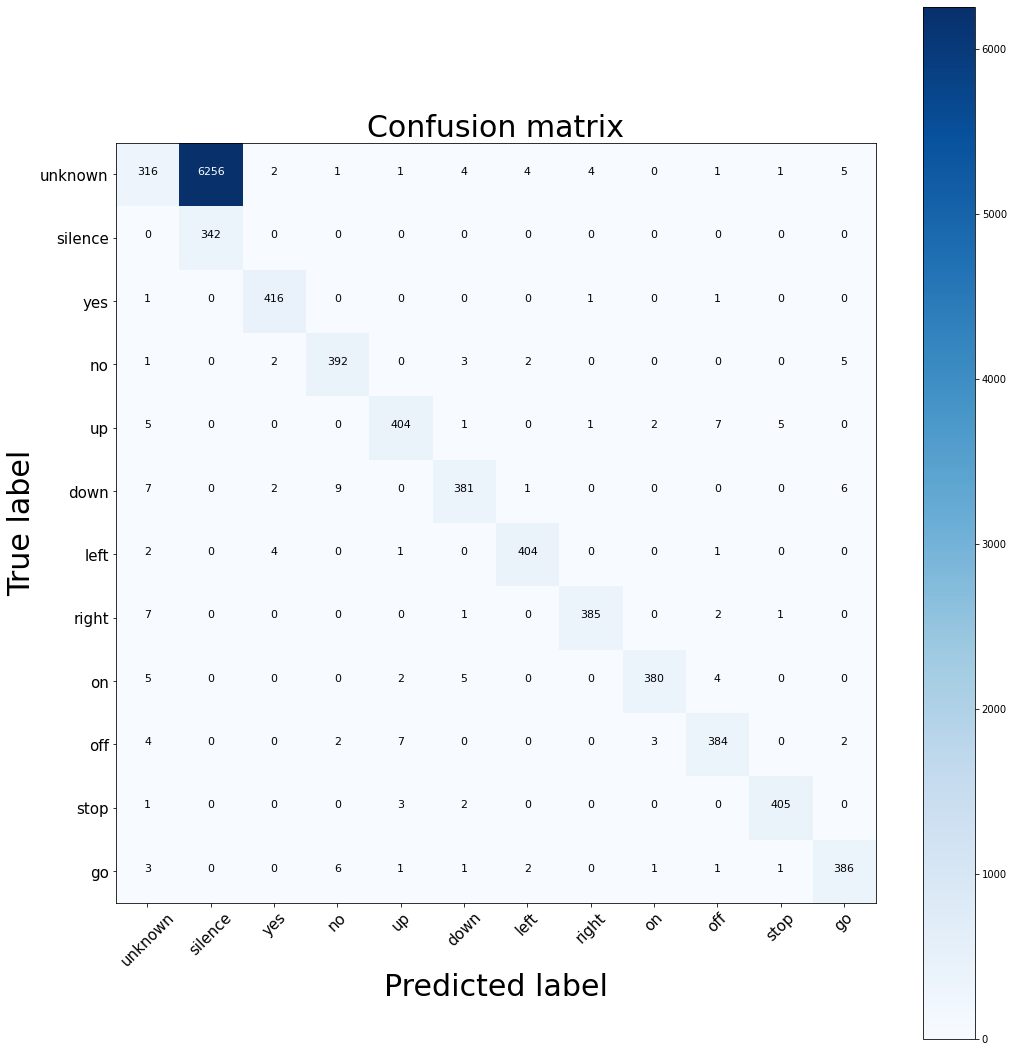

In [ ]:
# after balanced data creation there is a bug - don't care about biggest number (over 6k) in unknow row
audioUtils.plot_confusion_matrix(cm, classes, normalize=False)